# Imports

In [1]:
import numpy as np
import pandas as pd
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import squarify

import sys
import json
from copy import deepcopy

sys.path.append("..")
sys.path.append("../..")

from cge_modeling import Variable, Parameter, Equation, CGEModel
from cge_modeling.pytensorf.compile import (
    compile_cge_model_to_pytensor,
    euler_approximation_from_CGEModel,
    pytensor_objects_from_CGEModel,
)

In [2]:
from itertools import chain, compress
from cge_modeling.base.utilities import variable_dict_to_flat_array
from cge_modeling.production_functions import CES, dixit_stiglitz, leontief
from cge_modeling.gams.from_excel import make_code_dicts

code_dicts = make_code_dicts("data/GTAP_raw_data.xlsx")

In [3]:
import networkx as nx
import graphviz as gr

# Utility Functions

In [4]:
def draw_graph(edge_list, node_props=None, edge_props=None, graph_direction="UD"):
    """Utility to draw a causal (directed) graph"""
    g = gr.Digraph(graph_attr={"rankdir": graph_direction})

    edge_props = {} if edge_props is None else edge_props
    for e in edge_list:
        props = edge_props[e] if e in edge_props else {}
        g.edge(e[0], e[1], **props)

    if node_props is not None:
        for name, props in node_props.items():
            g.node(name=name, **props)
    return g


from cge_modeling.pytensorf.compile import object_to_pytensor, make_printer_cache, normalize_eq
import pytensor


def make_or_update_cache(pt_vars, pt_params, cache=None, allow_overwrite=False):
    new_cache = make_printer_cache(pt_vars, pt_params)
    new_cache = {k[0]: v for k, v in new_cache.items()}
    if cache is not None:
        for k, v in new_cache.items():
            if k in cache.keys() and not allow_overwrite:
                raise KeyError(
                    f"{k} already exists in cache, check code for duplicate declarations."
                )
            cache[k] = v
    else:
        cache = new_cache
    return cache


def convert_to_pt(variables, parameters, coords, cache=None, allow_overwrite=False):
    pt_vars = [object_to_pytensor(var, coords) for var in variables]
    pt_params = [object_to_pytensor(param, coords) for param in parameters]
    cache = make_or_update_cache(pt_vars, pt_params, cache, allow_overwrite=allow_overwrite)

    return pt_vars, pt_params, cache


def convert_equations(equations, coords, cache=None):
    pt_eqs = []
    for eq in equations:
        try:
            x = eval(normalize_eq(eq.equation), cache.copy())
            pt_eqs.append(x)
        except Exception as e:
            print(f"Could not compile equation: {eq.name}")
            print(e)
            raise e

    return pt_eqs


def test_equations(
    variables, parameters, equations, coords, cache=None, verbose=True, allow_overwrite=True
):
    pt_vars, pt_params, cache = convert_to_pt(
        variables, parameters, coords, cache, allow_overwrite=allow_overwrite
    )

    pt_eqs = convert_equations(equations, coords, cache)

    inputs = list(cache.values())

    rng = np.random.default_rng()
    value_dict = {var.name: rng.beta(1, 1, size=var.type.shape) for var in inputs}

    f = pytensor.function(inputs, pt_eqs, on_unused_input="ignore")
    out = f(**value_dict)
    if verbose:
        for x, name in zip([pt_vars, pt_params, pt_eqs], ["variables", "parameters", "equations"]):
            print(f"Found {len(x)} {name}")
        print(f"Output shapes: {[x.shape for x in out]}")

In [5]:
df = pd.read_csv("data/SRB_SAM_reduced.csv", index_col=[0, 1], header=[0, 1])

In [6]:
energy_dict = code_dicts["energy"]
energy_codes_base = list(energy_dict.keys())
energy_names_base = list(energy_dict.values())
energy_names = sorted(
    list(
        set(
            [
                (
                    x.replace("baseload", "")
                    .replace("peakload", "")
                    .replace("Other", "Other power")
                    .strip()
                )
                for x in energy_names_base
            ]
        )
    )
)
energy_codes = [x.split()[0] + "P" for x in energy_names]


sector_dict = code_dicts["activity"]
sector_dict_rev = {v: k for k, v in sector_dict.items()}

sector_names = sorted([x for x in sector_dict.values() if x not in energy_names_base])
# sector_codes = [sector_dict_rev[x] for x in sector_names]
sector_codes = ["Ag", "Ind", "Serv"]


n_sectors = len(sector_codes)
n_energy = len(energy_codes)

coords = {
    "i": sector_codes,
    "j": sector_codes,
    "k": energy_codes,
    "g": energy_codes,
    "egrid": 1,
    "v": ["Domestic", "Imported"],
}

In [7]:
sectors = sector_codes
eprod = energy_codes  # ["coal", "nuc"]
n_sectors = len(sectors)
n_eprod = len(eprod)
coords = {
    "i": sectors,
    "j": sectors,
    "k": eprod,
    "g": eprod,
    "egrid": 1,
    "v": ["Domestic", "Import"],
}
BACKEND = "pytensor"

# Model Definition

## Producers of Final Consumption Goods

### Structure

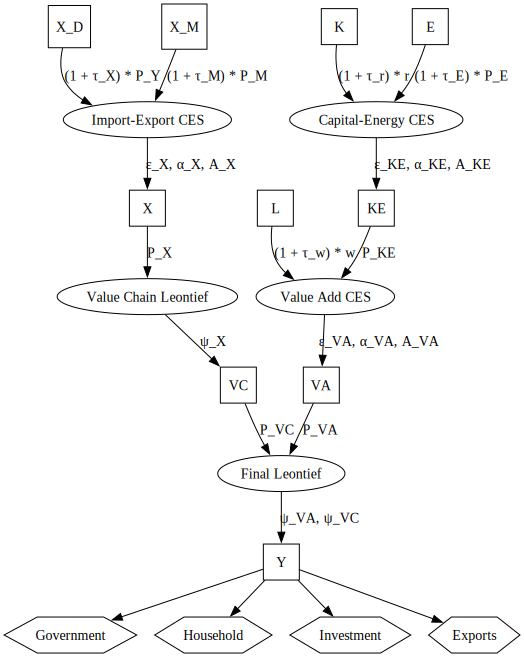

In [8]:
node_props = dict.fromkeys(
    ["VA", "VC", "X", "X_D", "X_M", "K", "E", "KE", "L", "Y"], {"shape": "square"}
)
node_props.update(
    dict.fromkeys(["Government", "Household", "Investment", "Exports"], {"shape": "hexagon"})
)

draw_graph(
    edge_list=[
        ("X_D", "Import-Export CES"),
        ("X_M", "Import-Export CES"),
        ("Import-Export CES", "X"),
        ("X", "Value Chain Leontief"),
        ("Value Chain Leontief", "VC"),
        ("K", "Capital-Energy CES"),
        ("E", "Capital-Energy CES"),
        ("Capital-Energy CES", "KE"),
        ("KE", "Value Add CES"),
        ("L", "Value Add CES"),
        ("Value Add CES", "VA"),
        ("VA", "Final Leontief"),
        ("VC", "Final Leontief"),
        ("Final Leontief", "Y"),
        ("Y", "Government"),
        ("Y", "Household"),
        ("Y", "Investment"),
        ("Y", "Exports"),
    ],
    node_props=node_props,
    edge_props={
        ("K", "Capital-Energy CES"): {"label": "(1 + τ_r) * r"},
        ("E", "Capital-Energy CES"): {"label": "(1 + τ_E) * P_E"},
        ("Capital-Energy CES", "KE"): {"label": "ε_KE, α_KE, A_KE"},
        ("X_D", "Import-Export CES"): {"label": "(1 + τ_X) * P_Y"},
        ("X_M", "Import-Export CES"): {"label": "(1 + τ_M) * P_M"},
        ("Import-Export CES", "X"): {"label": "ε_X, α_X, A_X"},
        ("KE", "Value Add CES"): {"label": "P_KE"},
        ("L", "Value Add CES"): {"label": "(1 + τ_w) * w"},
        ("Value Add CES", "VA"): {"label": "ε_VA, α_VA, A_VA"},
        ("X", "Value Chain Leontief"): {"label": "P_X"},
        ("Value Chain Leontief", "VC"): {"label": "ψ_X"},
        ("VA", "Final Leontief"): {"label": "P_VA"},
        ("VC", "Final Leontief"): {"label": "P_VC"},
        ("Final Leontief", "Y"): {"label": "ψ_VA, ψ_VC"},
    },
    graph_direction="UD",
)

### Implementation

#### Variables

In [9]:
final_firm_variables = [
    # Final Output
    Variable(name="Y", dims=("i", "v"), description="Final output in the <dim:i> sector"),
    # Intermediate Outputs (4)
    Variable(name="VA", dims="i", description="Value-added component of <dim:i> sector production"),
    Variable(name="VC", dims="i", description="Value-chain component of <dim:i> sector production"),
    Variable(
        name="X_bundled",
        dims=("i", "j"),
        extend_subscript=True,
        description="Demand for bundle of import and domestic <dim:i> sector goods bundle by the <dim:j> sector as value-chain inputs",
    ),
    Variable(
        name="KE",
        dims="i",
        extend_subscript=True,
        description="Labor Capital demand in the <dim:i> sector",
    ),
    # Root inputs (5)
    Variable(
        name="X",  # Called X_D and X_M on the graph above
        dims=("i", "j", "v"),
        description="Demand for <dim:v> <dim:i> sector goods by the <dim:j> sector as value-chain inputs",
    ),
    Variable(
        name="L_d",
        dims="i",
        extend_subscript=True,
        description="Labor demand in the <dim:i> sector",
    ),
    Variable(
        name="K_d",
        dims="i",
        extend_subscript=True,
        description="Capital demand in the <dim:i> sector",
    ),
    Variable(
        name="E_d",
        dims="i",
        extend_subscript=True,
        description="Energy demand in the <dim:i> sector",
    ),
    ## Prices (9)
    # Root factors (3)
    Variable(name="r", description="Rental rate of capital"),
    Variable(name="w", description="Wage level"),
    Variable(
        name="P_E",
        extend_subscript=True,
        description="Price of electricity",
    ),
    # Intermediate Outputs (4)
    Variable(
        name="P_X",
        dims=["i", "j"],
        extend_subscript=True,
        description="Price of sector <dim:i> Armington mix in sector <dim:j>",
    ),
    Variable(
        name="P_KE",
        dims="i",
        extend_subscript=True,
        description="Price of the capital-labor bundle in the <dim:i> sector",
    ),
    Variable(
        name="P_VA",
        dims="i",
        extend_subscript=True,
        description="Price of the value-add component in the <dim:i> sector",
    ),
    Variable(
        name="P_VC",
        dims="i",
        extend_subscript=True,
        description="Price of the value-chain component in the <dim:i> sector",
    ),
    # Final Prices (2) [domestic + foreign]
    Variable(
        name="P_Y",
        dims=["i", "v"],
        extend_subscript=True,
        description="<dim:v> final good price in the <dim:i> sector",
    ),
]

#### Parameters

In [10]:
final_firm_parameters = [
    # CES share parameters (3)
    Parameter(
        "alpha_KE",
        dims="i",
        description="Share of capital in production of the <dim:i> producer capital labour bundle",
    ),
    Parameter(
        "alpha_VA",
        dims="i",
        description="Share of capital in production of the <dim:i> sector value-add bundle",
    ),
    Parameter("alpha_X", dims=("i", "j"), description="Bias for domestic <dim:i> goods in <dim:j>"),
    # CES TFP Parameters (3)
    Parameter("A_VA", dims="i", description="Total factor productivity of the <dim:i> sector"),
    Parameter(
        "A_KE",
        dims="i",
        description="Total factor productivity of Capital-Energy Bundling in the <dim:i> sector",
    ),
    Parameter(
        "A_X",
        dims=["i", "j"],
        description="Total factor productivity of bundling <dim:i> goods in <dim:j> sector",
    ),
    # CES Elasticity Parameters (3)
    Parameter(
        name="epsilon_VA",
        extend_subscript=True,
        dims="i",
        description="Elasticity of subsitution between input factors in <dim:i> sector VA bundle",
    ),
    Parameter(
        name="epsilon_KE",
        extend_subscript=True,
        dims="i",
        description="Elasticity of subsitution between input factors in <dim:i> producer KL bundle",
    ),
    Parameter(
        name="epsilon_X",
        extend_subscript=True,
        dims=["i", "j"],
        description="Elasticity between home and imported good varieties of <dim:i> goods in sector <dim:j>",
    ),
    # Leontief share parameters (3)
    Parameter(
        "psi_VA",
        extend_subscript=True,
        dims="i",
        description="Share of value-add bundle in <dim:i> sector final good production",
    ),
    Parameter(
        "psi_VC",
        extend_subscript=True,
        dims="i",
        description="Share of value chain bundle in <dim:i> sector final good production",
    ),
    Parameter(
        "psi_X",
        extend_subscript=True,
        dims=("i", "j"),
        description="Share of <dim:i> sector final goods in the <dim:j> value chain bundle",
    ),
    # Tax rates (5)
    Parameter(
        "tau_w", extend_subscript=True, dims="i", description="Payroll rax tate in <dim:i> sector"
    ),
    Parameter(
        "tau_r",
        extend_subscript=True,
        dims="i",
        description="Capital use tax tax rate in <dim:i> sector",
    ),
    Parameter(
        "tau_E",
        extend_subscript=True,
        dims="i",
        description="Electricity tax rate in <dim:i> sector",
    ),
    Parameter(
        "tau_X",
        extend_subscript=True,
        dims=("i", "j", "v"),
        description="VAT tax paid by <dim:j> on <dim:v> <dim:i> sector inputs",
    ),
]

#### Equations

In [11]:
capital_energy_bundle = CES(
    factors=["K_d", "E_d"],
    factor_prices=["(1 + tau_r) * r", "(1 + tau_E) * P_E"],
    output="KE",
    output_price="P_KE",
    TFP="A_KE",
    factor_shares="alpha_KE",
    epsilon="epsilon_KE",
    backend=BACKEND,
)

value_add_bundle = CES(
    factors=["KE", "L_d"],
    factor_prices=["P_KE", "(1 + tau_w) * w"],
    output="VA",
    output_price="P_VA",
    TFP="A_VA",
    factor_shares="alpha_VA",
    epsilon="epsilon_VA",
    backend=BACKEND,
)

import_domestic_bundle = CES(
    factors=["X[..., 0]", "X[..., 1]"],
    factor_prices=[
        "(1 + tau_X[..., 0]) * P_Y[:, 0, None]",
        "(1 + tau_X[..., 1]) * P_Y[:, 1, None]",
    ],
    output="X_bundled",
    output_price="P_X",
    TFP="A_X",
    factor_shares="alpha_X",
    epsilon="epsilon_X",
    dims=["i", "j"],
    backend=BACKEND,
)

value_chain_bundle = leontief(
    factors="X_bundled",
    factor_prices="P_X",
    factor_shares="psi_X",
    output="VC",
    output_price="P_VC",
    dims=["i", "j"],
    coords=coords,
    backend=BACKEND,
)

final_goods = leontief(
    factors=["VC", "VA"],
    factor_prices=["P_VC", "P_VA"],
    factor_shares=["psi_VC", "psi_VA"],
    output="Y[:, 0]",
    output_price="P_Y[:, 0]",
    dims="i",
    coords=coords,
    backend=BACKEND,
)

In [12]:
final_firm_equations = [
    # Value chain bundle
    Equation(
        "Sector <dim:i> production of intermediate goods bundle",
        value_chain_bundle[0],
    ),
    Equation(
        "Sector <dim:i> demand for sector <dim:j> intermediate input",
        value_chain_bundle[1],
    ),
    # Armington Bundle
    Equation(
        "Sector <dim:i> production of <dim:j> import-domestic bundle", import_domestic_bundle[0]
    ),
    Equation("Sector <dim:i> demand for domestic <dim:j> inputs", import_domestic_bundle[1]),
    Equation("Sector <dim:i> demand for imported <dim:j> inputs", import_domestic_bundle[2]),
    # Capital Labour aggregation
    Equation("Producer <dim:i> production of capital-energy bundle", capital_energy_bundle[0]),
    Equation("Producer <dim:i> demand for captial", capital_energy_bundle[1]),
    Equation("Producer <dim:i> demand for energy", capital_energy_bundle[2]),
    # Value add bundle
    Equation("Sector <dim:i> production of value add", value_add_bundle[0]),
    Equation("Sector <dim:i> demand for capital energy bundle", value_add_bundle[1]),
    Equation("Sector <dim:i> demand for labour", value_add_bundle[2]),
    # Sector Final Goods
    Equation("Final good production of sector <dim:i>", final_goods[0]),
    Equation("Sector <dim:i> demand for intermediate goods bundle", final_goods[1]),
    Equation("Sector <dim:i> demand for value added", final_goods[2]),
]

##### Test Equations

In [13]:
*_, cache = convert_to_pt(final_firm_variables, final_firm_parameters, coords)
test_equations(final_firm_variables, final_firm_parameters, final_firm_equations, coords)

Found 17 variables
Found 16 parameters
Found 14 equations
Output shapes: [(3,), (3, 3), (3, 3), (3, 3), (3, 3), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,)]


## Producers of Energy

### Structure

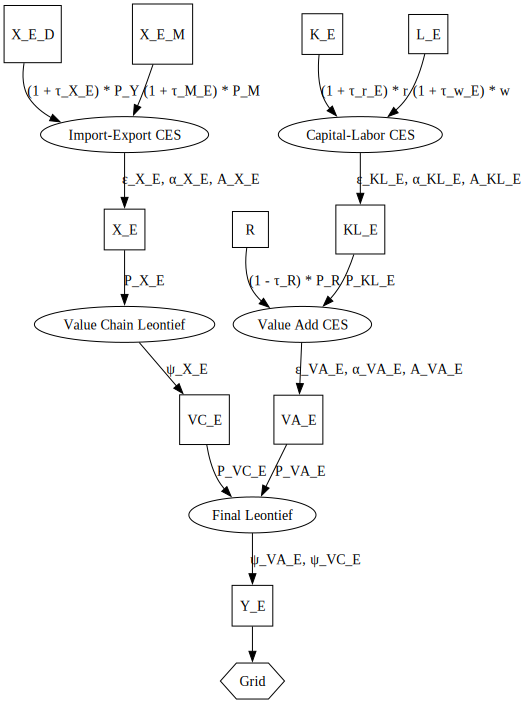

In [14]:
node_props = dict.fromkeys(
    ["VA_E", "VC_E", "X_E", "X_E_D", "X_E_M", "K_E", "R", "KL_E", "L_E", "Y_E"], {"shape": "square"}
)
node_props.update(dict.fromkeys(["Grid"], {"shape": "hexagon"}))

draw_graph(
    edge_list=[
        ("X_E_D", "Import-Export CES"),
        ("X_E_M", "Import-Export CES"),
        ("Import-Export CES", "X_E"),
        ("X_E", "Value Chain Leontief"),
        ("Value Chain Leontief", "VC_E"),
        ("K_E", "Capital-Labor CES"),
        ("L_E", "Capital-Labor CES"),
        ("Capital-Labor CES", "KL_E"),
        ("KL_E", "Value Add CES"),
        ("R", "Value Add CES"),
        ("Value Add CES", "VA_E"),
        ("VA_E", "Final Leontief"),
        ("VC_E", "Final Leontief"),
        ("Final Leontief", "Y_E"),
        ("Y_E", "Grid"),
    ],
    node_props=node_props,
    edge_props={
        ("K_E", "Capital-Labor CES"): {"label": "(1 + τ_r_E) * r"},
        ("L_E", "Capital-Labor CES"): {"label": "(1 + τ_w_E) * w"},
        ("Capital-Labor CES", "KL_E"): {"label": "ε_KL_E, α_KL_E, A_KL_E"},
        ("X_E_D", "Import-Export CES"): {"label": "(1 + τ_X_E) * P_Y"},
        ("X_E_M", "Import-Export CES"): {"label": "(1 + τ_M_E) * P_M"},
        ("Import-Export CES", "X_E"): {"label": "ε_X_E, α_X_E, A_X_E"},
        ("KL_E", "Value Add CES"): {"label": "P_KL_E"},
        ("R", "Value Add CES"): {"label": "(1 - τ_R) * P_R"},
        ("Value Add CES", "VA_E"): {"label": "ε_VA_E, α_VA_E, A_VA_E"},
        ("X_E", "Value Chain Leontief"): {"label": "P_X_E"},
        ("Value Chain Leontief", "VC_E"): {"label": "ψ_X_E"},
        ("VA_E", "Final Leontief"): {"label": "P_VA_E"},
        ("VC_E", "Final Leontief"): {"label": "P_VC_E"},
        ("Final Leontief", "Y_E"): {"label": "ψ_VA_E, ψ_VC_E"},
    },
    graph_direction="UD",
)

### Implementation

#### Variables

In [15]:
energy_firm_variables = [
    # Top-level output (1)
    Variable(
        name="Y_E", dims=("k", "v"), description="Final <dim:v> output in the <dim:k> energy sector"
    ),
    # Intermediate outputs (4)
    Variable(name="VC_E", dims="k", description="Value-chain component of <dim:k> energy producer"),
    Variable(
        name="VA_E", dims="k", description="Value-added component of <dim:k> sector production"
    ),
    Variable(
        name="X_E_bundled",
        dims=("i", "k"),
        extend_subscript=True,
        description="Demand for bundle of import and domestic <dim:i> sector goods bundle by the <dim:k> sector as value-chain inputs",
    ),
    Variable(
        name="KL_E",
        dims="k",
        extend_subscript=True,
        description="Capital energy bundle Capital demand in the <dim:k> e-sector",
    ),
    # Root inputs (5)
    Variable(
        name="X_E",  # X_E_D and X_E_M in the graph above
        dims=("i", "k", "v"),
        description="Demand for <dim:v> <dim:i> sector goods by the <dim:k> sector",
    ),
    Variable(
        name="L_E_d",
        dims="k",
        extend_subscript=True,
        description="Labor demand in the <dim:k> e-sector",
    ),
    Variable(
        name="K_E_d",
        dims="k",
        extend_subscript=True,
        description="Capital demand in the <dim:k> e-sector",
    ),
    Variable(
        name="R_d",
        dims="k",
        extend_subscript=True,
        description="Raw resource demand of <dim:k> sector",
    ),
    ## Prices
    # Final output
    Variable(
        name="P_Y_E",
        dims=("k", "v"),
        extend_subscript=True,
        description="Price of <dim:v> energy output by <dim:k> sector",
    ),
    # Intermediate outputs (4)
    Variable(
        name="P_KL_E",
        dims="k",
        extend_subscript=True,
        description="Price of capital-labor bundle formed by <dim:k> sector",
    ),
    Variable(
        name="P_X_E",
        dims=["i", "k"],
        extend_subscript=True,
        description="Price of <dim:i> Armington bundle formed by <dim:k> sector",
    ),
    Variable(
        name="P_VA_E",
        dims="k",
        extend_subscript=True,
        description="Price of value-add bundle in <dim:k> sector",
    ),
    Variable(
        name="P_VC_E",
        dims="k",
        extend_subscript=True,
        description="Price of value chain bundle in <dim:k> sector",
    ),
    # Root inputs (5)
    # P_Y, r, w are defined above
    Variable(
        name="P_R",
        dims="k",
        extend_subscript=True,
        description="Price of <dim:k> raw resource input",
    ),
]

#### Parameters

In [16]:
energy_firm_parameters = [
    # CES share parameters (3)
    Parameter(
        "alpha_KL_E",
        dims="k",
        description="Share of capital in production of the <dim:k> producer capital labour bundle",
    ),
    Parameter(
        "alpha_VA_E",
        dims="k",
        description="Share of capital in production of the <dim:k> producer capital labour bundle",
    ),
    Parameter(
        "alpha_X_E",
        dims=["i", "k"],
        description="Home bias for <dim:i> goods in the <dim:k> sector",
    ),
    # CES TFP parameters (3)
    Parameter(
        "A_KL_E", dims="k", description="Captial Labour factor productivity of <dim:k> producer"
    ),
    Parameter("A_VA_E", dims="k", description="Total factor productivity of the <dim:k> sector"),
    Parameter(
        "A_X_E",
        dims=["i", "k"],
        description="Total factor productivity bundling <dim:i> goods in the <dim:k> sector ",
    ),
    # CES elasticity parameters (3)
    Parameter(
        name="epsilon_KL_E",
        extend_subscript=True,
        dims="k",
        description="Elasticity of subsitution between capial and labor in <dim:k>",
    ),
    Parameter(
        name="epsilon_VA_E",
        extend_subscript=True,
        dims="k",
        description="Elasticity of subsitution between VA and VC in <dim:k>",
    ),
    Parameter(
        name="epsilon_X_E",
        dims=["i", "k"],
        description="Elesticity of substitution between domestic and imported <dim:i> varieties in <dim:k>",
    ),
    # Leontief share parameters (3)
    Parameter(
        "psi_X_E",
        extend_subscript=True,
        dims=("i", "k"),
        description="Share of <dim:g> sector final goods in the <dim:k> value chain bundle",
    ),
    Parameter(
        "psi_VC_E",
        extend_subscript=True,
        dims="k",
        description="Share of value chain bundle in <dim:k> sector final good production",
    ),
    Parameter(
        "psi_VA_E",
        extend_subscript=True,
        dims="k",
        description="Share of value add bundle in <dim:k> sector final good production",
    ),
    # Tax rates (5)
    Parameter(
        "tau_w_E", extend_subscript=True, dims="k", description="Payroll rax tate in <dim:k> sector"
    ),
    Parameter(
        "tau_r_E",
        extend_subscript=True,
        dims="k",
        description="Capital use tax rate in <dim:k> sector",
    ),
    Parameter(
        "tau_R",
        extend_subscript=True,
        dims="k",
        description="Raw material tax rate in <dim:k> sector",
    ),
    Parameter(
        "tau_X_E",
        extend_subscript=True,
        dims=("i", "k", "v"),
        description="VAT tax paid by <dim:k> sector on <dim:v> <dim:i> inputs",
    ),
]

#### Equations

In [17]:
capital_labor_bundle = CES(
    factors=["K_E_d", "L_E_d"],
    factor_prices=["(1 + tau_r_E) * r", "(1 + tau_w_E) * w"],
    output="KL_E",
    output_price="P_KL_E",
    TFP="A_KL_E",
    factor_shares="alpha_KL_E",
    epsilon="epsilon_KL_E",
    backend=BACKEND,
)

value_add_bundle = CES(
    factors=["KL_E", "R_d"],
    factor_prices=["P_KL_E", "(1 + tau_R) * R_d"],
    output="VA_E",
    output_price="P_VA_E",
    TFP="A_VA_E",
    factor_shares="alpha_VA_E",
    epsilon="epsilon_VA_E",
    backend=BACKEND,
)

import_domestic_bundle = CES(
    factors=["X_E[..., 0]", "X_E[..., 1]"],
    factor_prices=[
        "(1 + tau_X_E[..., 0]) * P_Y[:, 0, None]",
        "(1 + tau_X_E[..., 1]) * P_Y[:, 1, None]",
    ],
    output="X_E_bundled",
    output_price="P_X_E",
    TFP="A_X_E",
    factor_shares="alpha_X_E",
    epsilon="epsilon_X_E",
    dims=["i", "k"],
    backend=BACKEND,
)

value_chain_bundle = leontief(
    factors="X_E_bundled",
    factor_prices="P_X_E",
    factor_shares="psi_X_E",
    output="VC_E",
    output_price="P_VC_E",
    dims=["i", "k"],
    coords=coords,
    backend=BACKEND,
)

final_goods = leontief(
    factors=["VC_E", "VA_E"],
    factor_prices=["P_VC_E", "P_VA_E"],
    factor_shares=["psi_VC_E", "psi_VA_E"],
    output="Y_E[:, 0]",
    output_price="P_Y_E[:, 0]",
    dims="k",
    coords=coords,
    backend=BACKEND,
)

In [18]:
energy_firm_equations = [
    # Value chain bundle
    Equation(
        "Sector <dim:i> production of intermediate goods bundle",
        value_chain_bundle[0],
    ),
    Equation(
        "Sector <dim:k> demand for sector <dim:i> intermediate input",
        value_chain_bundle[1],
    ),
    # Armington Bundle
    Equation(
        "Sector <dim:k> production of <dim:i> import-domestic bundle", import_domestic_bundle[0]
    ),
    Equation("Sector <dim:k> demand for domestic <dim:i> inputs", import_domestic_bundle[1]),
    Equation("Sector <dim:k> demand for imported <dim:i> inputs", import_domestic_bundle[2]),
    # Capital Labour aggregation
    Equation("Producer <dim:k> production of capital-labor bundle", capital_labor_bundle[0]),
    Equation("Producer <dim:k> demand for captial", capital_labor_bundle[1]),
    Equation("Producer <dim:k> demand for labor", capital_labor_bundle[2]),
    # Value add bundle
    Equation("Sector <dim:k> production of value add", value_add_bundle[0]),
    Equation("Sector <dim:k> demand for capital energy bundle", value_add_bundle[1]),
    Equation("Sector <dim:k> demand for labour", value_add_bundle[2]),
    # Sector Final Goods
    Equation("Final good production of sector <dim:k>", final_goods[0]),
    Equation("Sector <dim:k> demand for intermediate goods bundle", final_goods[1]),
    Equation("Sector <dim:k> demand for value added", final_goods[2]),
]

In [19]:
*_, cache = convert_to_pt(
    energy_firm_variables, energy_firm_parameters, coords, cache, allow_overwrite=True
)
test_equations(
    energy_firm_variables, energy_firm_parameters, energy_firm_equations, coords, cache=cache
)

Found 15 variables
Found 16 parameters
Found 14 equations
Output shapes: [(8,), (3, 8), (3, 8), (3, 8), (3, 8), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,)]


## Electricity Producer (Grid)

### Structure

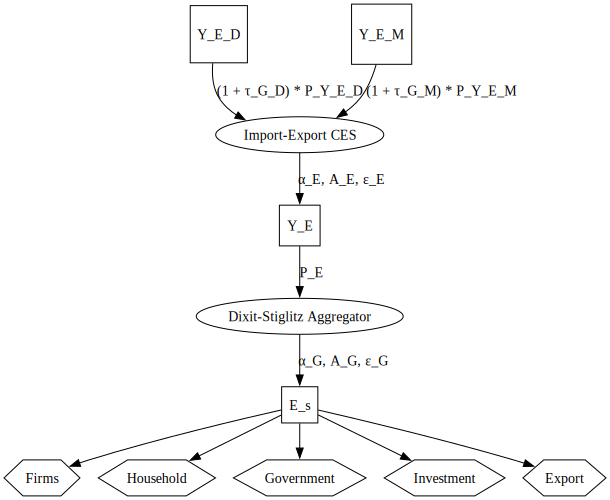

In [20]:
node_props = dict.fromkeys(["Y_E_D", "Y_E_M", "Y_E", "E_s"], {"shape": "square"})
node_props.update(
    dict.fromkeys(
        ["Firms", "Household", "Government", "Investment", "Export"], {"shape": "hexagon"}
    )
)

draw_graph(
    edge_list=[
        ("Y_E_D", "Import-Export CES"),
        ("Y_E_M", "Import-Export CES"),
        ("Import-Export CES", "Y_E"),
        ("Y_E", "Dixit-Stiglitz Aggregator"),
        ("Dixit-Stiglitz Aggregator", "E_s"),
        ("E_s", "Firms"),
        ("E_s", "Household"),
        ("E_s", "Government"),
        ("E_s", "Investment"),
        ("E_s", "Export"),
    ],
    node_props=node_props,
    edge_props={
        ("Y_E_D", "Import-Export CES"): {"label": "(1 + τ_G_D) * P_Y_E_D"},
        ("Y_E_M", "Import-Export CES"): {"label": "(1 + τ_G_M) * P_Y_E_M"},
        ("Import-Export CES", "Y_E"): {"label": "α_E, A_E, ε_E"},
        ("Y_E", "Dixit-Stiglitz Aggregator"): {"label": "P_E"},
        ("Dixit-Stiglitz Aggregator", "E_s"): {"label": "α_G, A_G, ε_G"},
    },
    graph_direction="UD",
)

### Implementation

#### Variables

In [21]:
grid_variables = [
    # Final Output
    Variable(name="E_s", description="Total electricity supplied by the grid"),
    # Intermediate Output
    Variable(
        "Y_E_bundled",
        dims="k",
        extend_subscript=True,
        description="Import-export bundle for energy produced by <dim:k> sector",
    ),
    # Inputs
    Variable(
        name="Y_E_d",
        dims=("k", "v"),
        extend_subscript=True,
        description="<dim:v> energy produced by <dim:k> demanded by the grid",
    ),
    # Intermediate input Y_E already defined above
    # Price P_E, P_Y_E, already defined above
    Variable(
        name="P_Y_E_bundled",
        dims="k",
        extend_subscript=True,
        description="Price of import-export for <dim:k> energy formed by the grid",
    ),
]

#### Parameters

In [22]:
grid_parameters = [
    # CES Parameters (3)
    Parameter(
        name="alpha_E", dims=["k"], description="Grid home bias for <dim:k> energy purchases"
    ),
    Parameter(
        name="A_E",
        dims=["k"],
        description="Total factor productivity of import-export bundling for <dim:k> energy purchases",
    ),
    Parameter(
        name="epsilon_E",
        dims=["k"],
        description="Elasticity of substitution between domestic and imported <dim:k> energy varieties",
    ),
    # DX Parameters (3)
    Parameter(
        name="alpha_G",
        dims="k",
        description="Share of <dim:k> energy in the production of electricity",
    ),
    Parameter(name="A_G", description="Total factor productivity of grid electricity production"),
    Parameter(
        name="epsilon_G",
        description="Elasticity of subsitution between energy varieties in grid production",
    ),
    # Taxes
    Parameter(
        name="tau_G",
        dims=["k", "v"],
        extend_subscript=True,
        description="<dim:v> sales tax on <dim:k> energy purchases by the grid",
    ),
]

#### Equations

In [23]:
import_domestic_bundle = CES(
    factors=["Y_E[:, 0]", "Y_E[:, 1]"],
    factor_prices=["(1 + tau_G[:, 0]) * P_Y_E[:, 0]", "(1 + tau_G[:, 1]) * P_Y_E[:, 1]"],
    output="Y_E_bundled",
    output_price="P_Y_E_bundled",
    TFP="A_E",
    factor_shares="alpha_E",
    epsilon="epsilon_E",
    dims=["k", "v"],
    backend=BACKEND,
)

electricity_production = dixit_stiglitz(
    factors="Y_E_bundled",
    factor_prices="P_Y_E_bundled",
    output="E_s",
    output_price="P_E",
    TFP="A_G",
    factor_shares="alpha_G",
    epsilon="epsilon_G",
    dims="k",
    coords=coords,
    backend=BACKEND,
)

In [24]:
grid_equations = [
    # Armington Bundle
    Equation("Grid production of <dim:k> import-domestic bundle", import_domestic_bundle[0]),
    Equation("Grid demand for domestic <dim:k> energy", import_domestic_bundle[1]),
    Equation("Grid demand for imported <dim:k> energy", import_domestic_bundle[2]),
    # Production of electricity
    Equation("Grid production of electricity", electricity_production[0]),
    Equation("Grid demand for <dim:k> energy", electricity_production[1]),
]

In [25]:
*_, cache = convert_to_pt(grid_variables, grid_parameters, coords, cache)
test_equations(grid_variables, grid_parameters, grid_equations, coords, cache)

Found 4 variables
Found 7 parameters
Found 5 equations
Output shapes: [(8,), (8,), (8,), (), (8,)]


## Household

### Structure

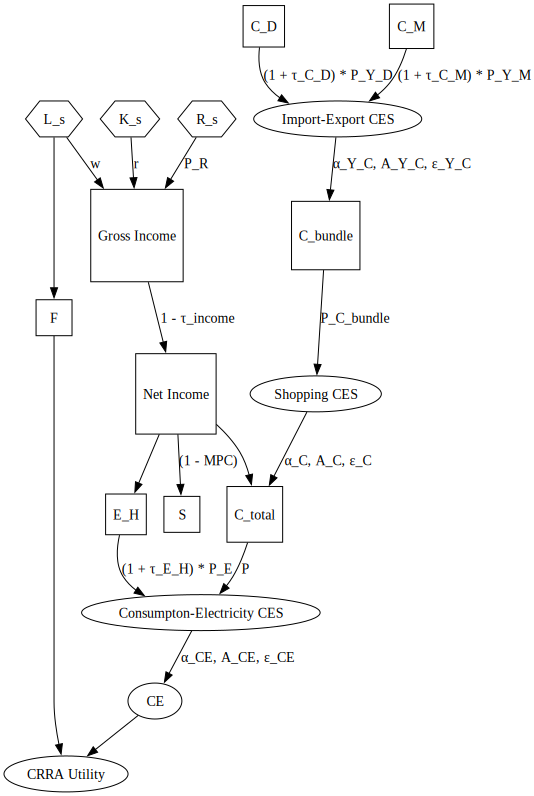

In [26]:
node_props = dict.fromkeys(
    ["C_D", "C_M", "E_H", "L_s", "F", "S", "C_bundle", "C_total", "Gross Income", "Net Income"],
    {"shape": "square"},
)
node_props.update(dict.fromkeys(["K_s", "R_s", "L_s"], {"shape": "hexagon"}))

draw_graph(
    edge_list=[
        ("C_D", "Import-Export CES"),
        ("C_M", "Import-Export CES"),
        ("Import-Export CES", "C_bundle"),
        ("C_bundle", "Shopping CES"),
        ("Shopping CES", "C_total"),
        ("C_total", "Consumpton-Electricity CES"),
        ("E_H", "Consumpton-Electricity CES"),
        ("Consumpton-Electricity CES", "CE"),
        ("L_s", "F"),
        ("F", "CRRA Utility"),
        ("CE", "CRRA Utility"),
        ("L_s", "Gross Income"),
        ("K_s", "Gross Income"),
        ("R_s", "Gross Income"),
        ("Gross Income", "Net Income"),
        ("Net Income", "C_total"),
        ("Net Income", "S"),
        ("Net Income", "E_H"),
    ],
    node_props=node_props,
    edge_props={
        ("C_D", "Import-Export CES"): {"label": "(1 + τ_C_D) * P_Y_D"},
        ("C_M", "Import-Export CES"): {"label": "(1 + τ_C_M) * P_Y_M"},
        ("Import-Export CES", "C_bundle"): {"label": "α_Y_C, A_Y_C, ε_Y_C"},
        ("C_bundle", "Shopping CES"): {"label": "P_C_bundle"},
        ("Shopping CES", "C_total"): {"label": "α_C, A_C, ε_C"},
        ("L_s", "Gross Income"): {"label": "w"},
        ("K_s", "Gross Income"): {"label": "r"},
        ("R_s", "Gross Income"): {"label": "P_R"},
        ("Net Income", "S"): {"label": "(1 - MPC)"},
        ("Gross Income", "Net Income"): {"label": "1 - τ_income"},
        ("E_H", "Consumpton-Electricity CES"): {"label": "(1 + τ_E_H) * P_E"},
        ("C_total", "Consumpton-Electricity CES"): {"label": "P"},
        ("Consumpton-Electricity CES", "CE"): {"label": "α_CE, A_CE, ε_CE"},
    },
    graph_direction="UD",
)

### Implementation

#### Variables

In [27]:
household_variables = [
    # Inputs to shopping
    Variable(
        name="C",  # Called C_M and C_D above
        dims=("i", "v"),
        description="Household demand for <dim:v> <dim:i> goods",
    ),
    Variable(
        name="C_bundled",
        dims="i",
        description="Sector <dim:i> import-domestic bundle formed by households",
    ),
    # Inputs to final consumption basket
    Variable(name="E_H_d", description="Household demand for electricity"),
    Variable(
        name="C_total", latex_name="\bar{C}", description="Household final consumption bundle"
    ),
    # Spending variables
    Variable(name="F", description="Household leisure time"),
    Variable(name="S", description="Household savings"),
    Variable(name="CE", description="Consumption-Electricity bundle"),
    # Income definitions
    Variable(name="L_s", description="Household supply of labor"),
    Variable(
        name="income",  # Gross Income above
        latex_name="Omega",
        description="Household income, before taxes",
    ),
    Variable(
        name="net_income", latex_name="\hat{\Omega}", description="Household income, after taxes"
    ),
    # Prices
    Variable(
        name="P_C_bundled",
        dims="i",
        description="Price of the import-domestic bundle for <dim:i> goods",
    ),
    Variable(name="P", description="Core CPI, excluding electricity"),
    Variable(name="P_CE", description="Consumper Price Index"),
    # Utility
    Variable(name="U", description="Household utility"),
]

#### Parameters

In [28]:
household_parameters = [
    # Factor endowments
    Parameter(name="T", description="Time endowment"),
    Parameter(name="K_s", description="Capital stock"),
    Parameter(name="R_s", dims="k", description="Endowment of <dim:k> resource factor"),
    # Armington Parameters
    Parameter(
        name="alpha_C_M", dims=("i",), description="Household home bias in for <dim:i> goods"
    ),
    Parameter(
        name="A_C_M",
        dims=("i",),
        description="Household total factor productivity bundling domestic and imported <dim:i> goods",
    ),
    Parameter(
        name="epsilon_C_M",
        dims=("i",),
        description="Household elasticity of substitution between domestic and imported <dim:i> goods",
    ),
    # Shopping CES parameters
    Parameter(
        name="alpha_C",
        dims="i",
        description="Household elasticity of consumption utility for <dim:i> sector goods",
    ),
    Parameter(name="A_C", description="Household total factor productivity of shopping"),
    Parameter(
        name="epsilon_C",
        description="Elasticity of substitution between varieties in final consumption basket",
    ),
    # Consumption-Electricity Mix
    Parameter(name="alpha_CE", description="Share of goods consumption relative to electricity"),
    Parameter(name="A_CE", description="TFP of combining consumption basket and electricity"),
    Parameter(
        name="epsilon_CE",
        description="Elasticity of substitution between consumption basket and electricity",
    ),
    # Utility Parameters
    Parameter(
        name="sigma_C",
        description="Arrow-Pratt risk averson",
    ),
    Parameter(name="sigma_L", description="Inverse Frisch elasticity between work and leisure"),
    Parameter(name="Theta", description="Household labor dispreference parameter"),
    # Miscellaneous
    Parameter(name="mpc", latex_name="phi", description="Household marginal propensity to consume"),
    # Taxes
    Parameter(
        name="tau_C",
        dims=["i", "v"],
        description="Sales tax paid by households for <dim:v> <dim:i> goods",
    ),
    Parameter(name="tau_E_H", description="Sales tax paid by households for electricity"),
    Parameter(name="tau_income", description="Income tax paid by households"),
]

#### Equations

In [29]:
import_domestic_bundle = CES(
    factors=["C[:, 0]", "C[:, 1]"],
    factor_prices=["(1 + tau_C[:, 0]) * P_Y[:, 0]", "(1 + tau_C[:, 1]) * P_Y[:, 1]"],
    output="C_bundled",
    output_price="P_C_bundled",
    TFP="A_C_M",
    factor_shares="alpha_C_M",
    epsilon="epsilon_C_M",
    dims=["i", "v"],
    backend=BACKEND,
)

shopping_function = dixit_stiglitz(
    factors="C_bundled",
    factor_prices="P_C_bundled",
    output="C_total",
    output_price="P",
    TFP="A_C",
    factor_shares="alpha_C",
    epsilon="epsilon_C",
    dims="i",
    coords=coords,
    backend=BACKEND,
)

consumption_electricity_bundle = CES(
    factors=["C_total", "E_H_d"],
    factor_prices=["P", "(1 + tau_E_H) * P_E"],
    output="CE",
    output_price="P_CE",
    TFP="A_CE",
    factor_shares="alpha_CE",
    epsilon="epsilon_CE",
    backend=BACKEND,
)

In [30]:
household_equations = [
    # Import-Domestic Bundling
    Equation("Household production of <dim:i> import-domestic bundle", import_domestic_bundle[0]),
    Equation("Household demand for domestic <dim:i> goods", import_domestic_bundle[1]),
    Equation("Household demand for imported <dim:i> goods", import_domestic_bundle[2]),
    # Production of consumption basket (shopping)
    Equation("Final consumption bundle", shopping_function[0]),
    Equation("Household demand for <dim:i> goods", shopping_function[1]),
    # Basket-Electricity bundle
    Equation("Goods-Electricity bundle", consumption_electricity_bundle[0]),
    Equation("Household demand for goods basket", consumption_electricity_bundle[1]),
    Equation("Household demand for electricity", consumption_electricity_bundle[2]),
    # Income
    Equation(
        "Household pre-tax income",
        "income = w * L_s + r * K_s + (R_s * P_R).sum()",
    ),
    Equation("Household after-tax income", "net_income = (1 - tau_income) * income"),
    Equation(
        "Household budget constraint",
        "C_total * P + E_H_d * (1 + tau_E_H) * P_E = mpc * net_income",
    ),
    Equation(
        "Household utility",
        "U = CE ** (1 - sigma_C) / (1 - sigma_C) + F ** (1 - sigma_L) / (1 - sigma_L)",
    ),
    Equation("Household supply of labor", "F ** -sigma_L / CE ** -sigma_C = w / P_CE / Theta"),
    Equation("Household savings", "S = (1 - mpc) * net_income"),
]

In [31]:
*_, cache = convert_to_pt(
    household_variables, household_parameters, coords, cache, allow_overwrite=True
)
test_equations(household_variables, household_parameters, household_equations, coords, cache)

Found 14 variables
Found 19 parameters
Found 14 equations
Output shapes: [(3,), (3,), (3,), (), (3,), (), (), (), (), (), (), (), (), ()]


## Investment

### Structure

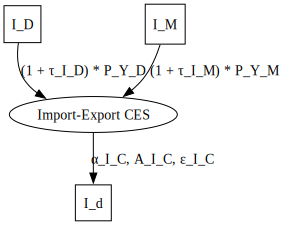

In [32]:
node_props = dict.fromkeys(["I_D", "I_M", "I_d"], {"shape": "square"})

draw_graph(
    edge_list=[
        ("I_D", "Import-Export CES"),
        ("I_M", "Import-Export CES"),
        ("Import-Export CES", "I_d"),
    ],
    node_props=node_props,
    edge_props={
        ("I_D", "Import-Export CES"): {"label": "(1 + τ_I_D) * P_Y_D"},
        ("I_M", "Import-Export CES"): {"label": "(1 + τ_I_M) * P_Y_M"},
        ("Import-Export CES", "I_d"): {"label": "α_I_C, A_I_C, ε_I_C"},
    },
    graph_direction="UD",
)

### Implementation

#### Variables

In [33]:
investment_variables = [
    Variable(
        name="I_d",
        dims=["i", "v"],
        description="Demand for <dim:v> investment capital by the <dim:i> sector",
    ),
    Variable(
        name="I_bundled", dims="i", description="Investment capital demanded by the <dim:i> sector"
    ),
    Variable(
        name="P_I_bundled",
        dims="i",
        description="Price of domestic-imported investment bundle in the <dim:i> sector",
    ),
]

#### Parameters

In [34]:
investment_parameters = [
    Parameter("I_s", description="Aggregate investment supply"),
    Parameter("alpha_k", description="<dim:k> share of total investment"),
    Parameter(name="alpha_I", dims=("i",), description="Household home bias in for <dim:i> goods"),
    Parameter(
        name="A_I",
        dims=("i",),
        description="Household total factor productivity bundling domestic and imported <dim:i> goods",
    ),
    Parameter(
        name="epsilon_I",
        dims=("i",),
        description="Household elasticity of substitution between domestic and imported <dim:i> goods",
    ),
    Parameter(
        name="tau_I",
        dims=("i", "v"),
        description="Tax rate paid by sector <dim:i> on capital investment",
    ),
]

#### Equations

In [35]:
import_domestic_bundle = CES(
    factors=["I_d[:, 0]", "I_d[:, 1]"],
    factor_prices=["(1 + tau_I[:, 0]) * P_Y[:, 0]", "(1 + tau_I[:, 1]) * P_Y[:, 1]"],
    output="I_bundled",
    output_price="P_I_bundled",
    TFP="A_I",
    factor_shares="alpha_I",
    epsilon="epsilon_I",
    dims=["i", "v"],
    backend=BACKEND,
)

In [36]:
investment_equations = [
    Equation("<dim:i> sector demand for domestic-import capital bundle", import_domestic_bundle[0]),
    Equation("<dim:i> sector demand for domestic capital", import_domestic_bundle[1]),
    Equation("<dim:i> sector demand for imported capital", import_domestic_bundle[2]),
    Equation("<dim:i> sector demand for capital", "P_I_bundled * I_bundled = I_s"),
]

In [37]:
*_, cache = convert_to_pt(
    investment_variables, investment_parameters, coords, cache, allow_overwrite=True
)
test_equations(investment_variables, investment_parameters, investment_equations, coords, cache)

Found 3 variables
Found 6 parameters
Found 4 equations
Output shapes: [(3,), (3,), (3,), (3,)]


## Government

### Structure

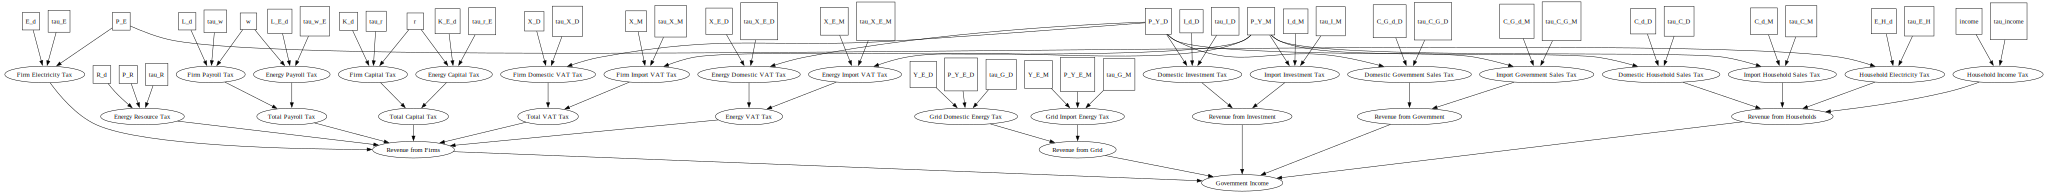

In [38]:
all_taxes = [
    "tau_w",
    "tau_w_E",
    "tau_r",
    "tau_r_E",
    "tau_E",
    "tau_E_H",
    "tau_X_D",
    "tau_X_M",
    "tau_X_E_D",
    "tau_X_E_M",
    "tau_C_D",
    "tau_C_M",
    "tau_C_G_D",
    "tau_C_G_M",
    "tau_I_D",
    "tau_I_M",
    "tau_G_D",
    "tau_G_M",
    "tau_R",
    "tau_income",
]
taxed_prices = ["P_Y_D", "P_Y_M", "w", "r", "P_Y_E_M", "P_Y_E_D", "P_E", "P_R"]

taxed_quantities = [
    "L_d",
    "L_E_d",
    "K_d",
    "K_E_d",
    "E_d",
    "E_H_d",
    "X_D",
    "X_M",
    "X_E_D",
    "X_E_M",
    "R_d",
    "I_d_M",
    "I_d_D",
    "income",
    "Y_E_D",
    "Y_E_M",
    "C_G_d_D",
    "C_G_d_M",
    "C_d_D",
    "C_d_M",
]

node_props = dict.fromkeys(all_taxes + taxed_prices + taxed_quantities, {"shape": "square"})

draw_graph(
    edge_list=[
        ("L_d", "Firm Payroll Tax"),
        ("w", "Firm Payroll Tax"),
        ("tau_w", "Firm Payroll Tax"),
        ("L_E_d", "Energy Payroll Tax"),
        ("tau_w_E", "Energy Payroll Tax"),
        ("w", "Energy Payroll Tax"),
        ("K_d", "Firm Capital Tax"),
        ("r", "Firm Capital Tax"),
        ("tau_r", "Firm Capital Tax"),
        ("K_E_d", "Energy Capital Tax"),
        ("tau_r_E", "Energy Capital Tax"),
        ("r", "Energy Capital Tax"),
        ("X_D", "Firm Domestic VAT Tax"),
        ("P_Y_D", "Firm Domestic VAT Tax"),
        ("tau_X_D", "Firm Domestic VAT Tax"),
        ("X_M", "Firm Import VAT Tax"),
        ("P_Y_M", "Firm Import VAT Tax"),
        ("tau_X_M", "Firm Import VAT Tax"),
        ("E_d", "Firm Electricity Tax"),
        ("P_E", "Firm Electricity Tax"),
        ("tau_E", "Firm Electricity Tax"),
        ("R_d", "Energy Resource Tax"),
        ("P_R", "Energy Resource Tax"),
        ("tau_R", "Energy Resource Tax"),
        ("X_E_D", "Energy Domestic VAT Tax"),
        ("tau_X_E_D", "Energy Domestic VAT Tax"),
        ("P_Y_D", "Energy Domestic VAT Tax"),
        ("X_E_M", "Energy Import VAT Tax"),
        ("tau_X_E_M", "Energy Import VAT Tax"),
        ("P_Y_M", "Energy Import VAT Tax"),
        ("Y_E_D", "Grid Domestic Energy Tax"),
        ("P_Y_E_D", "Grid Domestic Energy Tax"),
        ("tau_G_D", "Grid Domestic Energy Tax"),
        ("Y_E_M", "Grid Import Energy Tax"),
        ("P_Y_E_M", "Grid Import Energy Tax"),
        ("tau_G_M", "Grid Import Energy Tax"),
        ("I_d_D", "Domestic Investment Tax"),
        ("P_Y_D", "Domestic Investment Tax"),
        ("tau_I_D", "Domestic Investment Tax"),
        ("I_d_M", "Import Investment Tax"),
        ("P_Y_M", "Import Investment Tax"),
        ("tau_I_M", "Import Investment Tax"),
        ("C_G_d_D", "Domestic Government Sales Tax"),
        ("P_Y_D", "Domestic Government Sales Tax"),
        ("tau_C_G_D", "Domestic Government Sales Tax"),
        ("C_G_d_M", "Import Government Sales Tax"),
        ("P_Y_M", "Import Government Sales Tax"),
        ("tau_C_G_M", "Import Government Sales Tax"),
        ("C_d_D", "Domestic Household Sales Tax"),
        ("P_Y_D", "Domestic Household Sales Tax"),
        ("tau_C_D", "Domestic Household Sales Tax"),
        ("C_d_M", "Import Household Sales Tax"),
        ("P_Y_M", "Import Household Sales Tax"),
        ("tau_C_M", "Import Household Sales Tax"),
        ("E_H_d", "Household Electricity Tax"),
        ("P_E", "Household Electricity Tax"),
        ("tau_E_H", "Household Electricity Tax"),
        ("income", "Household Income Tax"),
        ("tau_income", "Household Income Tax"),
        ("Firm Payroll Tax", "Total Payroll Tax"),
        ("Energy Payroll Tax", "Total Payroll Tax"),
        ("Total Payroll Tax", "Revenue from Firms"),
        ("Firm Capital Tax", "Total Capital Tax"),
        ("Energy Capital Tax", "Total Capital Tax"),
        ("Total Capital Tax", "Revenue from Firms"),
        ("Firm Domestic VAT Tax", "Total VAT Tax"),
        ("Firm Import VAT Tax", "Total VAT Tax"),
        ("Total VAT Tax", "Revenue from Firms"),
        ("Energy Domestic VAT Tax", "Energy VAT Tax"),
        ("Energy Import VAT Tax", "Energy VAT Tax"),
        ("Energy VAT Tax", "Revenue from Firms"),
        ("Firm Electricity Tax", "Revenue from Firms"),
        ("Energy Resource Tax", "Revenue from Firms"),
        ("Grid Domestic Energy Tax", "Revenue from Grid"),
        ("Grid Import Energy Tax", "Revenue from Grid"),
        ("Domestic Investment Tax", "Revenue from Investment"),
        ("Import Investment Tax", "Revenue from Investment"),
        ("Domestic Government Sales Tax", "Revenue from Government"),
        ("Import Government Sales Tax", "Revenue from Government"),
        ("Household Electricity Tax", "Revenue from Households"),
        ("Import Household Sales Tax", "Revenue from Households"),
        ("Domestic Household Sales Tax", "Revenue from Households"),
        ("Household Income Tax", "Revenue from Households"),
        ("Revenue from Grid", "Government Income"),
        ("Revenue from Firms", "Government Income"),
        ("Revenue from Investment", "Government Income"),
        ("Revenue from Government", "Government Income"),
        ("Revenue from Households", "Government Income"),
    ],
    node_props=node_props,
    edge_props={},
    graph_direction="UD",
)

### Implementation

#### Variables

In [39]:
government_variables = [
    Variable(name="G", description="Government budget"),
    Variable(
        name="C_G",
        dims=("i", "v"),
        extend_subscript=True,
        description="Government consumption of <dim:v> <dim:i> goods",
    ),
    Variable(
        name="C_G_bundled",
        dims=("i",),
        extend_subscript=True,
        description="Government <dim:i> domestic-imported bundle",
    ),
    Variable(
        name="P_C_G_bundled",
        dims=("i",),
        extend_subscript=True,
        description="Price of government domestic-import bundle for <dim:i> sector goods",
    ),
    Variable(
        name="S_G",
        extend_subscript=True,
        positive=None,
        description="Investment capital supplied by government",
    ),
]

#### Parameters

In [40]:
government_parameteres = [
    Parameter(
        "alpha_Gov",
        dims="i",
        description="Share of <dim:i> sector final goods in governmnet consumption",
    ),
    Parameter(
        name="alpha_C_G", dims=("i",), description="Government home bias in for <dim:i> goods"
    ),
    Parameter(
        name="A_C_G",
        dims=("i",),
        description="Government total factor productivity bundling domestic and imported <dim:i> goods",
    ),
    Parameter(
        name="epsilon_C_G",
        dims=("i",),
        description="Government elasticity of substitution between domestic and imported <dim:i> goods",
    ),
    Parameter(
        name="tau_C_G",
        dims=("i", "v"),
        description="Tax rate paid by government for <dim:v> sector <dim:i> goods",
    ),
    Parameter(name="S_G", description="Government Savings"),
]

#### Equations

In [41]:
import_domestic_bundle = CES(
    factors=["C_G[:, 0]", "C_G[:, 1]"],
    factor_prices=["(1 + tau_C_G[:, 0]) * tau_C_G[:, 0]", "(1 + tau_C_G[:, 1]) * tau_C_G[:, 1]"],
    output="C_G_bundled",
    output_price="P_C_G_bundled",
    TFP="A_C_G",
    factor_shares="alpha_C_G",
    epsilon="epsilon_C_G",
    dims=["i", "v"],
    backend=BACKEND,
)

In [42]:
government_equations = [
    Equation(
        "Government budget constraint",
        "G + S_G = tau_income * income + "
        # Firm taxes
        "(tau_X * P_Y[:, None, :] * X).sum() + "  # Firm VAT (domestic + foreign)
        "(tau_w * L_d * w).sum() +"  # Firm payroll tax
        "(tau_r * K_d * r).sum() +"  # Firm capital use tax
        "(tau_E * E_d * P_E).sum() +"  # Firm electricity
        # Energy producer taxes
        "(tau_X_E * P_Y[:, None, :] * X_E).sum() +"  # Energy VAT (domestic + foreign)
        "(tau_w_E * L_E_d * w).sum() +"  # Energy payroll tax
        "(tau_r_E * K_E_d * r).sum() +"  # Energy capital use tax
        "(tau_R * R_d * P_R).sum() +"  # Energy resource use tax
        # Grid
        "(tau_G * Y_E * P_Y_E).sum() +"  # Energy inputs to electricity production (domestic + foreign)
        # Investment
        "(tau_I * I_d * P_Y).sum() +"  # Tax on capital investment (domestic + foreign)
        # Household
        "(tau_C * P_Y * C).sum() +"  # Consumption (domestic + foreign)
        "(tau_E_H * E_H_d * P_E).sum() +"  # Household electricity (domestic only)
        "(tau_income * income) +"  # Income tax (direct tax)
        # Government
        "(tau_C_G * P_Y * C_G).sum()",  # Consumption (domestic + foreign)
    ),
    Equation(
        "Government domestic-import bundle of <dim:i> sector goods", import_domestic_bundle[0]
    ),
    Equation("Government demand for domestic <dim:i> sector goods", import_domestic_bundle[1]),
    Equation("Government demand for imported <dim:i> sector goods", import_domestic_bundle[2]),
    Equation("Government consumption of <dim:i> sector goods", "C_G_bundled = alpha_Gov * G"),
]

In [43]:
*_, cache = convert_to_pt(
    government_variables, government_parameteres, coords, cache, allow_overwrite=True
)
test_equations(government_variables, government_parameteres, government_equations, coords, cache)

Found 5 variables
Found 6 parameters
Found 5 equations
Output shapes: [(), (3,), (3,), (3,), (3,)]


In [44]:
all_parameters = (
    final_firm_parameters
    + energy_firm_parameters
    + grid_parameters
    + household_parameters
    + investment_parameters
    + government_parameteres
)
all_variables = (
    final_firm_variables
    + energy_firm_variables
    + grid_variables
    + household_variables
    + investment_variables
    + government_variables
)
all_equations = (
    final_firm_equations
    + energy_firm_equations
    + grid_equations
    + household_equations
    + investment_equations
    + government_equations
)

pt_params, pt_vars, cache = convert_to_pt(all_variables, all_parameters, coords)
pt_eqs = convert_equations(all_equations, coords, cache)

## Market Clearing

### Structure

### Implementation

#### Variables

In [45]:
clearing_variables = [Variable("resid", description="Walrasian residual")]

#### Parameters

In [46]:
# Exogenous values
clearing_parameters = [
    Parameter("P_num", latex_name=r"\\bar{P}_{num}", description="Numeraire price"),
    Parameter(
        "export_demand",
        dims="i",
        latex_name=r"\\text{Ex}^d",
        description="Total <dim:i> demand for exports by RoW",
    ),
]

#### Equations

In [47]:
clearing_equations = [
    Equation("Investment market clearing", "I_s = S + S_G + resid"),
    Equation("Labour market clearing", "L_s = L_d.sum() + L_E_d.sum()"),
    Equation("Capital market clearing", "K_s = K_d.sum() + K_E_d.sum()"),
    Equation("Energy market clearing", "E_s = E_d.sum() + E_H_d"),
    Equation("Ressource energy market clearing <dim:k>", "R_s = R_d"),
    Equation(
        "Domestic sector <dim:i> goods market clearing",
        "Y[:, 0] = (C + C_G + I_d + X.sum(axis=1) + X_E.sum(axis=1))[:, 0]",
    ),
    Equation(
        "Imported sector <dim:i> goods market clearing",
        "Y[:, 1] = (C + C_G + I_d + X.sum(axis=1) + X_E.sum(axis=1))[:, 1]",
    ),
    Equation("<dim:i> sector investment market clearning", "P_Y * I_d = alpha_k * I_s"),
    Equation("Total time constraint", "T = L_s + F"),
    Equation("Numeraire", "P = P_num"),
]

In [51]:
all_parameters = (
    final_firm_parameters
    + energy_firm_parameters
    + grid_parameters
    + household_parameters
    + investment_parameters
    + government_parameteres
    + clearing_parameters
)
all_variables = (
    final_firm_variables
    + energy_firm_variables
    + grid_variables
    + household_variables
    + investment_variables
    + government_variables
    + clearing_variables
)
all_equations = (
    final_firm_equations
    + energy_firm_equations
    + grid_equations
    + household_equations
    + investment_equations
    + government_equations
    + clearing_equations
)

pt_vars, pt_params, cache = convert_to_pt(all_variables, all_parameters, coords)
pt_eqs = convert_equations(all_equations, coords, cache)

In [52]:
sum([np.prod(x.type.shape) for x in pt_vars])

369.0

In [53]:
sum([np.prod(x.type.shape) for x in pt_eqs])

348.0

In [153]:
variable_info = [
    # Raw energy producer
    Variable(
        name="Y_E_d",
        dims="k",
        extend_subscript=True,
        description="Raw energy demand of <dim:k> sector",
    ),
    # Prices (7)
    Variable(name="P", dims="i", description="Final good price in the <dim:i> sector, after taxes"),
    Variable(
        name="P_Y_E",
        dims=["k", "v"],
        extend_subscript=True,
        description="<dim:v> final good price in the <dim:k> energy sector, before taxes",
    ),
    Variable(
        name="P_R",
        dims="k",
        extend_subscript=True,
        description="Ressource energy price",
    ),
    Variable(
        name="P_Y_E_star",
        dims="k",
        extend_subscript=True,
        description="Electricity price level for purchasing <dim:k> energy",
    ),
    Variable(
        name="P_VC_E",
        dims="k",
        extend_subscript=True,
        description="Price of the value-chain component in the <dim:k> sector",
    ),
    Variable(
        name="P_KE_S",
        dims="i",
        extend_subscript=True,
        description="Capital labour bundle price in the <dim:i> sector",
    ),
    Variable(
        name="P_KL_E",
        dims="k",
        extend_subscript=True,
        description="Capital labour bundle price in the <dim:k> sector",
    ),
    Variable(
        name="P_E_star",
        dims="i",
        extend_subscript=True,
        description="Electricity after tax price of <dim:i> sector",
    ),
    Variable(
        name="P_W",
        dims="k",
        extend_subscript=True,
        description="Raw energy price",
    ),
    Variable(
        name="r_star_S",
        latex_name="r^\\star_S",
        dims=("i",),
        description="<dim:i> after-tax rental rate",
        positive=True,
    ),
    Variable(
        name="r_star_E",
        latex_name="r^\\star_E",
        dims=("k",),
        description="<dim:k> after-tax rental rate",
        positive=True,
    ),
    Variable(
        name="w_star_S",
        dims=("i",),
        latex_name="w^\\star_S",
        description="<dim: i> after-tax wage level",
        positive=True,
    ),
    Variable(
        name="w_star_E",
        dims=("k",),
        latex_name="w^\\star_E",
        description="<dim: k> after-tax wage level",
        positive=True,
    ),
    # Government variables
    # Misc
    Variable(name="resid", latex_name=r"varepsilon", description="Walrasian residual"),
    Variable(name="L_s", description="Household labor supply"),
    Variable(name="CPI", latex_name="P_C", description="Price of the household consumption basket"),
]

### Equations

In [ ]:
va_eqs = CES(
    factors=["KE_S_d", "L_S_d"],
    factor_prices=["P_KE_S", "w_star_S"],
    output="VA",
    output_price="P_VA",
    TFP="A_VA",
    factor_shares="alpha_VA",
    epsilon="epsilon_VA",
    backend=BACKEND,
)